<a href="https://colab.research.google.com/github/IslamiTP/Intro-to-LLM-Homework-2/blob/main/run_ollama_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run Ollama in Colab

### Code to initialize llama using Unsloth was retrieved from

https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing#scrollTo=2eSvM9zX_2d3

In [23]:
%%capture
!pip install unsloth

In [24]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [25]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 1, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [26]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)

def formatting_train_prompts(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

def tokenize_function(examples):
    return tokenizer(
        examples["text"],  # Use only text
        padding="max_length",
        truncation=True,
        max_length=2048,
        return_tensors="pt"
    )

from datasets import load_dataset

# Load the full dataset
full_dataset = load_dataset("mlabonne/FineTome-100k", split="train")

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)

# Access the train and test splits
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 80000
})
Test dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 20000
})


In [27]:
from unsloth.chat_templates import standardize_sharegpt
train_dataset = standardize_sharegpt(train_dataset)
train_dataset = train_dataset.map(formatting_train_prompts, batched = True,)
test_dataset = standardize_sharegpt(test_dataset)
test_dataset = test_dataset.map(formatting_train_prompts, batched=True)
tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

In [28]:
from unsloth.chat_templates import get_chat_template
import torch

# Assuming tokenizer and model are already loaded
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

# Define a list of messages (each entry follows the chat template format)


message_list = [
    [{"role": "system", "content": "You are a helpful AI assistant that specializes in summarizing text.\n\n"}, # Text Summarization
     {"role": "user", "content": "Summarize the following article in 2-3 sentences:\n\nIn recent years, the importance of renewable energy has grown significantly due to increasing concerns about climate change. Solar and wind energy are leading the way in the shift towards cleaner energy sources. Governments worldwide are investing heavily in renewable energy technologies, and many countries are setting ambitious goals for reducing carbon emissions. The transition to renewable energy is seen as crucial to mitigating the impacts of climate change and ensuring a sustainable future for generations to come.\n\n"}],

    [{"role": "system", "content": "You are an AI assistant that answers questions based on provided passages.\n\n"}, # Question Answering
     {"role": "user", "content": "Read the following passage and answer the question:\n\nThe Eiffel Tower is located in Paris, France. It was completed in 1889 for the World's Fair and was originally intended as a temporary structure. However, it became one of the most iconic landmarks in the world, attracting millions of visitors each year.\n\nQuestion: When was the Eiffel Tower completed?\n\n"}],

    [{"role": "system", "content": "You are an AI that classifies text into categories: Technology, Health, Sports, or Politics.\n\n"}, # Text Classification
     {"role": "user", "content": "Classify the following text:\n\nThe latest advancements in AI and machine learning are revolutionizing industries. Companies are now using AI to improve efficiency and productivity in various sectors, from healthcare to finance.\n\n"}],

    [{"role": "system", "content": "You are a customer support agent for an online course company. Respond helpfully to customers.\n\n"}, # Role Playing
     {"role": "user", "content": "Hi, I’m having trouble accessing the course I purchased. Can you help me?\n\n"}],

    [{"role": "system", "content": "Answer the following reasoning question:\n\n"}, #Reasoning
     {"role": "user", "content": "If all roses are flowers, and some flowers are red, can we conclude that some roses are red?\n\n"}]
]

# Store results
generated_outputs = []

# Iterate through message list and generate responses
for messages in message_list:
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Run inference without gradient tracking
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=2048,
            use_cache=True,
            temperature=1.5,
            min_p=0.1
        )

    # Decode and store the output
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_outputs.append(output_text)

prompt_types = ["Text Summarization", "Question Answering", "Text Classification", "Role Playing", "Reasoning"]

# Print all generated responses
for i, (response, messages, prompt_type) in enumerate(zip(generated_outputs, message_list, prompt_types)):
    print(f"Prompt Type: {prompt_type}\n\n")

    print(f"Response: {response}\n\n\n")

Prompt Type: Text Summarization


Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

You are a helpful AI assistant that specializes in summarizing text.

user

Summarize the following article in 2-3 sentences:

In recent years, the importance of renewable energy has grown significantly due to increasing concerns about climate change. Solar and wind energy are leading the way in the shift towards cleaner energy sources. Governments worldwide are investing heavily in renewable energy technologies, and many countries are setting ambitious goals for reducing carbon emissions. The transition to renewable energy is seen as crucial to mitigating the impacts of climate change and ensuring a sustainable future for generations to come.

assistant

Here is a 2-3 sentence summary of the article:

The importance of renewable energy has significantly grown due to climate change concerns. Solar and wind energy are at the forefront of the shift towards cleaner energy so

# Question #1
#### Grabbing questions from different datasets for text summarization, question answering, text classification, role playing, and reasoning

# Question #2
#### Fine-tuning using LORA and SFTTrainer which is a special trainer designed to fine-tune models.

In [29]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

max_seq_length = 2048
dtype = None  # Auto detection, change if needed
load_in_4bit = False  # Set to True if using 4bit quantization

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",  # Keep this as "text" since that's what formatting_func returns
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 9e-4,
        max_steps=60,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: We found double BOS tokens - we shall remove one automatically.


{'eval_loss': 1.4238659143447876, 'eval_model_preparation_time': 0.007, 'eval_runtime': 48.7568, 'eval_samples_per_second': 4.102, 'eval_steps_per_second': 0.513}
['conversations', 'source', 'score', 'text']


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 1,519,616/3,214,269,440 (0.05% trained)


Step,Training Loss
1,1.227900
2,1.273900
3,1.276000
4,1.224700
5,1.085000
6,1.033800
7,0.812000
8,0.841000
9,0.916000
10,0.946500


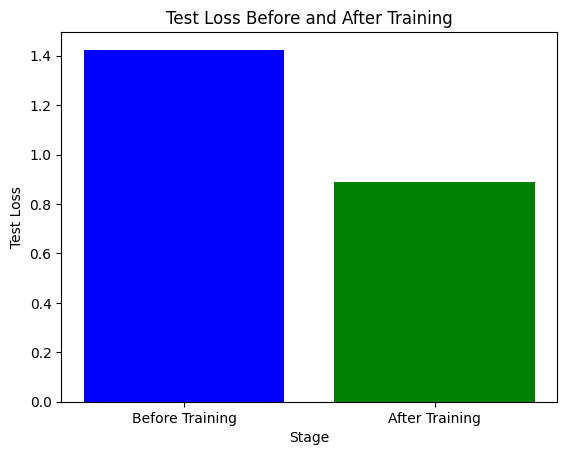

In [30]:
import matplotlib.pyplot as plt

# Assuming you already have the model, test_dataset, and trainer set up

# Calculate the test loss before training
trainer.model.eval()  # Set the model to evaluation mode

before_training_results = trainer.evaluate(tokenized_datasets.select(range(200)))
print(before_training_results)
before_training_loss = before_training_results["eval_loss"]

print(train_dataset.column_names)
# Train the model

trainer.train()

# Calculate the test loss after training
trainer.model.eval()  # Set the model back to evaluation mode
after_training_results = trainer.evaluate(tokenized_datasets.select(range(200)))
after_training_loss = after_training_results["eval_loss"]

# Prepare the data for the bar plot
losses = [before_training_loss, after_training_loss]
labels = ['Before Training', 'After Training']

# Create the bar plot
plt.bar(labels, losses, color=['blue', 'green'])
plt.xlabel('Stage')
plt.ylabel('Test Loss')
plt.title('Test Loss Before and After Training')
plt.show()

In [31]:
from unsloth.chat_templates import get_chat_template
import torch

# Assuming tokenizer and model are already loaded
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

# Define a list of messages (each entry follows the chat template format)

message_list = [
    [{"role": "system", "content": "You are a helpful AI assistant that specializes in summarizing text.\n\n"}, # Text Summarization
     {"role": "user", "content": "Summarize the following article in 2-3 sentences:\n\nIn recent years, the importance of renewable energy has grown significantly due to increasing concerns about climate change. Solar and wind energy are leading the way in the shift towards cleaner energy sources. Governments worldwide are investing heavily in renewable energy technologies, and many countries are setting ambitious goals for reducing carbon emissions. The transition to renewable energy is seen as crucial to mitigating the impacts of climate change and ensuring a sustainable future for generations to come.\n\n"}],

    [{"role": "system", "content": "You are an AI assistant that answers questions based on provided passages.\n\n"}, # Question Answering
     {"role": "user", "content": "Read the following passage and answer the question:\n\nThe Eiffel Tower is located in Paris, France. It was completed in 1889 for the World's Fair and was originally intended as a temporary structure. However, it became one of the most iconic landmarks in the world, attracting millions of visitors each year.\n\nQuestion: When was the Eiffel Tower completed?\n\n"}],

    [{"role": "system", "content": "You are an AI that classifies text into categories: Technology, Health, Sports, or Politics.\n\n"}, # Text Classification
     {"role": "user", "content": "Classify the following text:\n\nThe latest advancements in AI and machine learning are revolutionizing industries. Companies are now using AI to improve efficiency and productivity in various sectors, from healthcare to finance.\n\n"}],

    [{"role": "system", "content": "You are a customer support agent for an online course company. Respond helpfully to customers.\n\n"}, # Role Playing
     {"role": "user", "content": "Hi, I’m having trouble accessing the course I purchased. Can you help me?\n\n"}],

    [{"role": "system", "content": "Answer the following reasoning question:\n\n"}, #Reasoning
     {"role": "user", "content": "If all roses are flowers, and some flowers are red, can we conclude that some roses are red?\n\n"}]
]

# Store results
generated_outputs = []

# Iterate through message list and generate responses
for messages in message_list:
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Run inference without gradient tracking
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=2048,
            use_cache=True,
            temperature=1.5,
            min_p=0.1
        )

    # Decode and store the output
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_outputs.append(output_text)

prompt_types = ["Text Summarization", "Question Answering", "Text Classification", "Role Playing", "Reasoning"]

# Print all generated responses
for i, (response, messages, prompt_type) in enumerate(zip(generated_outputs, message_list, prompt_types)):
    print(f"Prompt Type: {prompt_type}\n\n")

    print(f"Response: {response}\n\n\n")

Prompt Type: Text Summarization


Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

You are a helpful AI assistant that specializes in summarizing text.

user

Summarize the following article in 2-3 sentences:

In recent years, the importance of renewable energy has grown significantly due to increasing concerns about climate change. Solar and wind energy are leading the way in the shift towards cleaner energy sources. Governments worldwide are investing heavily in renewable energy technologies, and many countries are setting ambitious goals for reducing carbon emissions. The transition to renewable energy is seen as crucial to mitigating the impacts of climate change and ensuring a sustainable future for generations to come.

assistant

Here is a 2-3 sentence summary of the article:

The growing importance of renewable energy is a major response to climate change. Solar and wind energy are at the forefront of the shift towards cleaner energy sources. Ma